# Stock Market Index Prediction using Time-series and Daily News Text Analysis
## Simple and Multilinear Linear Regression Approaches
### Preprocessing and Modeling

In [249]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime as dt

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,6

pd.set_option('mode.chained_assignment', 'raise') # Raise an exception, warn, or no action if trying to use chained assignment

In [250]:
# Read the combines stock index CSV data file from the data directory
dataset = pd.read_csv('data/comb_data_final.csv',index_col='Date',parse_dates=True)

In [251]:
# Create a separate dataset
new_data = dataset.reset_index()[['Date', 'Adj Close']]
new_data.head()

,Date,Adj Close
0,2008-08-08,11734.320312
1,2008-08-11,11782.349609
2,2008-08-12,11642.469727
3,2008-08-13,11532.959961
4,2008-08-14,11615.929688


In [252]:
new_data.shape

(1989, 2)

In [253]:
# Set the threshold two years before the last date (at the beginning of 7th year)
threshold = new_data['Date'].max() - pd.DateOffset(years=2) 
# Create Train and Test datasets
X_train = new_data[new_data['Date'] <= threshold]['Date']
X_test = new_data[new_data['Date'] > threshold]['Date']
y_train = new_data[new_data['Date'] <= threshold]['Adj Close']
y_test = new_data[new_data['Date'] > threshold]['Adj Close']
X_train.shape, X_test.shape

((1484,), (505,))

### Naive Method 1: Using past prices to predict future prices (Optional)
Dependent variable y is basically prices shifted upwards. We can decide how much we shift the price and the less days we shift it, the closer the prediction and lesser the error will be. This is because we are using lagged prices to predict the future prices in a linear fashion, thus making it a fairly simple model.

In [254]:
# I selected 250 days of shift of prices.
df1 = dataset.copy()[['Adj Close']]
df1['Prediction'] = df1[['Adj Close']].shift(-250) # dependent y column is basically prices shifted forwards
df1.dropna(inplace=True)

X = df1.drop(['Prediction'],1)
y = df1['Prediction']

X_train1 = X[:-505] # selected train/test split corresponds to 1484, 505 split (shown below)
y_train1 = y[:-505]
X_test1 = X[-505:]
y_test1 = y[-505:]
len(X_train1),len(y_train1), len(X_test1),len(y_test1)

(1234, 1234, 505, 505)

In [255]:
df1.head()

,Adj Close,Prediction
Date,,
2008-08-08,11734.320312,9256.259766
2008-08-11,11782.349609,9370.070312
2008-08-12,11642.469727,9337.950195
2008-08-13,11532.959961,9241.450195
2008-08-14,11615.929688,9361.610352


In [256]:
# Build linear model to use lagged prices to predict future prices
linreg1 = LinearRegression().fit(X_train1, y_train1)
predictions1 = linreg1.predict(X_test1)

In [257]:
# Root mean square error
rmse = np.sqrt(np.mean(np.power((np.array(y_test1)-np.array(predictions1)),2)))
rmse

1197.4281860443364

In [258]:
# Build a new dataset for the test data to plot the prediction result
X_test_copy = X_test1.copy()
X_test_copy['Prediction'] = predictions1

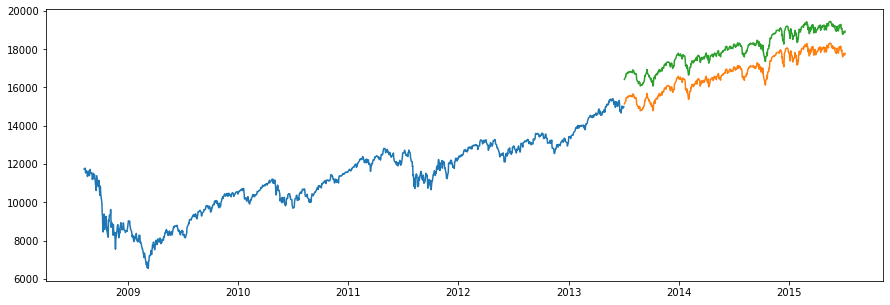

In [259]:
# Visualize the results
plt.figure(figsize=(15,5))
plt.plot(X_train1)
plt.plot(X_test_copy)

### Conclusion:
We can see that this is not a realistic method to use to predict index prices.

## Model 1: Simple Linear Regression Using datetime index 

We will be using the datetime index for our Sinple Linear Regression model.

In [260]:
# We are using the toordinal() function that returns the Gregorian ordinal of a date to transform the Date index to an ordinal form for ML algorithms to process
X_train=X_train.map(dt.datetime.toordinal)
X_test=X_test.map(dt.datetime.toordinal)

In [261]:
Train_dates = np.array(X_train).reshape(len(X_train),1)
Train_prices = np.array(y_train).reshape(len(y_train),1)
Test_dates = np.array(X_test).reshape(len(X_test),1)

### Model

In [262]:
#implement linear regression
model = LinearRegression()
model.fit(Train_dates,Train_prices)

#make predictions and find the rmse
preds = model.predict(Test_dates)

In [263]:
#make predictions and find the rmse
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse 

1013.4765066410042

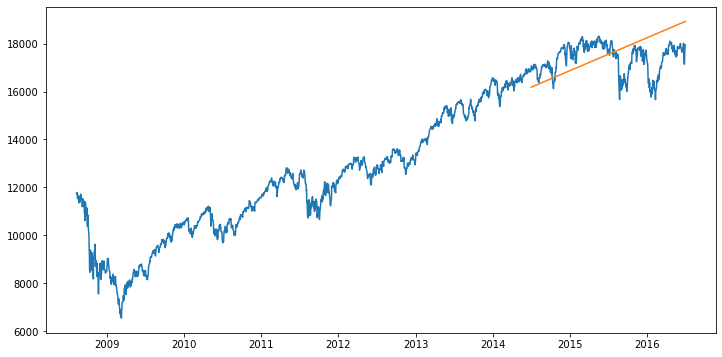

In [264]:
plt.plot(new_data['Date'],new_data['Adj Close']) #plotting the initial datapoints (full data)
plt.plot(X_test.map(dt.datetime.fromordinal),preds) #plotting the line made by linear regression (test and predictions)
plt.show()

## Model 2 - Multiple Linear Regression (w/ Feature Engineering)

In [265]:
new_data1 = new_data.copy()
new_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1989 non-null   datetime64[ns]
 1   Adj Close  1989 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.2 KB


In [266]:
# Feature engineering of extra columns
# Add new features made from Date column
new_data1['Year'] = new_data1['Date'].dt.year
new_data1['Month'] = new_data1['Date'].dt.month
new_data1['Week'] = new_data1['Date'].dt.isocalendar().week
new_data1['Day'] = new_data1['Date'].dt.day
new_data1['Dayofweek'] = new_data1['Date'].dt.dayofweek
new_data1['Dayofyear'] = new_data1['Date'].dt.dayofyear
new_data1['Is_month_start'] = new_data1['Date'].dt.is_month_start.astype('int')
new_data1['Is_month_end'] = new_data1['Date'].dt.is_month_end.astype('int')
new_data1['Is_quarter_start'] = new_data1['Date'].dt.is_quarter_start.astype('int')
new_data1['Is_quarter_end'] = new_data1['Date'].dt.is_quarter_end.astype('int')
new_data1['Is_year_start'] = new_data1['Date'].dt.is_year_start.astype('int')
new_data1['Is_year_end'] = new_data1['Date'].dt.is_year_end.astype('int')

In [267]:
new_data1['mon_fri'] = 0
for i in range(0,len(new_data1)):
    if (new_data1['Dayofweek'][i] == 0 or new_data1['Dayofweek'][i] == 4):
        new_data1.loc[i, 'mon_fri'] = 1

In [268]:
new_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1989 non-null   datetime64[ns]
 1   Adj Close         1989 non-null   float64       
 2   Year              1989 non-null   int64         
 3   Month             1989 non-null   int64         
 4   Week              1989 non-null   UInt32        
 5   Day               1989 non-null   int64         
 6   Dayofweek         1989 non-null   int64         
 7   Dayofyear         1989 non-null   int64         
 8   Is_month_start    1989 non-null   int32         
 9   Is_month_end      1989 non-null   int32         
 10  Is_quarter_start  1989 non-null   int32         
 11  Is_quarter_end    1989 non-null   int32         
 12  Is_year_start     1989 non-null   int32         
 13  Is_year_end       1989 non-null   int32         
 14  mon_fri           1989 n

In [269]:
# Create new Train and Test datasets
train = new_data1[:1484]
test = new_data1[1484:]

X_train = train.drop('Adj Close', axis=1)
X_test = test.drop('Adj Close', axis=1)
y_train = train['Adj Close']
y_test = test['Adj Close']

In [270]:
X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)

### Model

In [271]:
#implement liner regression
model2 = LinearRegression()
model2.fit(X_train,y_train)

#make predictions and find the rmse
preds = model2.predict(X_test)
preds[:10]

array([16163.61935458, 16165.72582362, 16186.25686234, 16184.1629277 ,
       16186.26939673, 16188.37586577, 16194.68273846, 16208.90690449,
       16206.81296985, 16208.91943887])

In [272]:
# Make predictions and find the rmse
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse

1024.7383516949112

In [170]:
## Optional: It is not a good measure to use to assess performance
lr_score = model2.score(X_test, y_test)
print("lr R^2 score: ", lr_score)

lr R^2 score:  -1.8564589916473477


In [274]:
## Assign a new column to plot the predictions
test_copy = test.copy()
test_copy['Predictions'] = preds

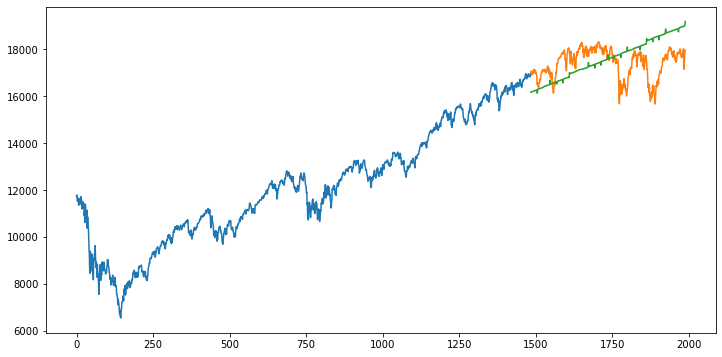

In [276]:
#plot
plt.plot(train['Adj Close'])
plt.plot(test_copy[['Adj Close','Predictions']])

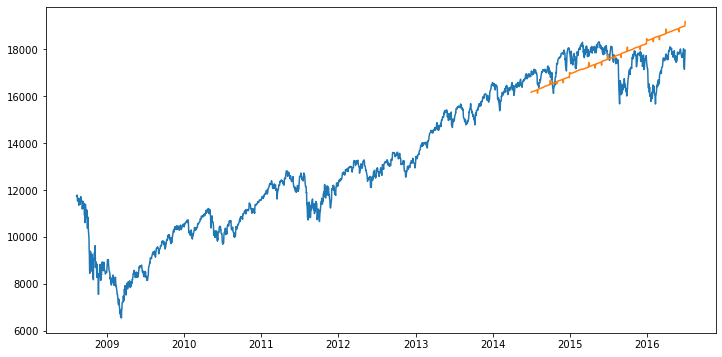

In [277]:
#### Alternative way to plot
plt.plot(new_data1['Date'],new_data1['Adj Close']) #plotting the initial datapoints (full data)
plt.plot(X_test['Date'].map(dt.datetime.fromordinal),preds) #plotting the line made by linear regression (test and predictions)
plt.show()